### [MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv](https://data.ny.gov/Transportation/MTA-Subway-Trains-Delayed-Beginning-2020/wx2t-qtaz/about_data)
Columns: 
- __month__: The month in which subway trains delayed is being calculated (yyyy-mm-dd).
- __division__: The A Division (numbered subway lines), B Division (lettered subway lines) and systemwide.
- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, J, Z, L, N, Q, R, W, S 42nd, S Rock, S Fkln).
- __day_type__: Represents weekday as 1 and weekend as 2.
- __reporting_category__: The six categories that delays are reported under: Infrastructure & equipment, Crew availability, Police & medical, External Factors, Operating conditions, Planned ROW work. 
- __subcategory__: The sub-categories that fall under the definition of Delays: Braking; Door-Related; Fire, Smoke, Debris; Inclement Weather; Crew Availability; Insufficient Supplement Schedule; Propulsion; Public Conduct, Crime, Police Response; Rail and Roadbed; Persons on Roadbed; Service Delivery; Sick/Injured Customer; Train Brake Activation - Cause Unknown; Subways Maintenance; Work Equipment; Capital Work - Other Planned ROW; External Debris on Roadbed; External Agency or Utility; Capital Work - Other Planned ROW; Other – CE; Other – Sig; Other Infrastructure; Other Internal Disruptions.
- __delays__: The number of train delays per category and time period.

### [MTA Subway Customer Journey-Focused Metrics: Beginning 2020](https://data.ny.gov/Transportation/MTA-Subway-Customer-Journey-Focused-Metrics-Beginn/4apg-4kt9/about_data)
- __month__: The month in which the metrics are being calculated (yyyy-mm-dd).

- __division__: The A Division (numbered subway lines and S 42nd) and B Division (lettered subway lines).

- __line__: Each subway line (1, 2, 3, 4, 5, 6, 7, A, C, E, B, D, F, M, G, JZ, L, N, Q, R, W, S 42nd, S Rock, S Fkln). A systemwide row also exists for each month in the dataset.

- __period__: Represents both the peak and off-peak service periods.

- __num_passengers__: Total number of passengers reported each month and on each line.

- __additional platform time__: The average additional time in minutes (above scheduled time) customers wait for their train, reported each month and on each line.

- __additional train time__: The average additional time in minutes (above scheduled time) customers spend onboard a train, reported each month and on each line.

- __total_apt__: The total number of additional time in minutes (above scheduled time) customers wait for their train, reported each month and on each line.

- __total_att__: The total number of average additional time in minutes (above scheduled time) customers spend onboard a train, reported each month and on each line.

- __over_five_mins__: The estimated total number of customers whose journeys are not completed within 5 minutes of the scheduled time, reported each month and on each line

- __over_five_mins_perc__: The estimated percentage of customers whose journeys are not completed within 5 minutes of the scheduled time, reported each month and on each line.

- __customer journey time performance__: The estimated percentage of customers whose journeys are completed within 5 minutes of the scheduled time, reported each month and on each line.


In [91]:
# lines grouped together based on delay frequency
line_groups = [
    ["N", "A", "F", "6", "2", "E"],
    ["Q", "D", "4", "1"],
    ["R", "7", "C", "5", "3"],
    ["L", "B", "JZ", "G", "M"]
]

group_to_use = line_groups[3]

# Data Cleaning

In [92]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# Load the dataset from the CSV file
file = 'MTA_Subway_Trains_Delayed__Beginning_2020_20241117.csv'
df = pd.read_csv(file)

# replace missing subcategories with reporting_category
df['subcategory'] = df['subcategory'].fillna(df['reporting_category'])

# replace "Other Operating Environment" with "Operating Conditions" to maintain parity
# a new "Service Management" subcategory was added in Aug 2024 which
# replaces the empty subcategory for "Operating Conditions"
df['subcategory'] = df['subcategory'].replace("Other Operating Environment", "Operating Conditions")

# drop the division and reporting_category columns, they are redundance info
df = df.drop(columns=['division', 'reporting_category'])

# remove S Rock, S Fkln, and GS (shuttles)
df = df[~df['line'].isin(['S Rock', 'S Fkln', 'GS'])]

df

,month,line,day_type,subcategory,delays
0,2024-10-01,1,1,Crew Availability,60
1,2024-10-01,1,1,External Debris on Roadbed,17
2,2024-10-01,1,1,Braking,20
3,2024-10-01,1,1,Door-Related,43
4,2024-10-01,1,1,"Fire, Smoke, Debris",30
...,...,...,...,...,...
39025,2020-01-01,R,2,Subways Maintenance,23
39026,2020-01-01,R,2,Work Equipment,3
39027,2020-01-01,R,2,Persons on Roadbed,4
39028,2020-01-01,R,2,"Public Conduct, Crime, Police Response",31


# Data Reshaping

In [93]:
# reshape the df each line
lines_df = {}
for line in df['line'].unique():
    line_df = df[df['line'] == line]

    # drop line since we're only looking at one line
    line_df = line_df.drop(columns=['line'])

    # pivot the delay subcategory rows into columns
    line_df = line_df.pivot(index=['month', 'day_type'], columns='subcategory', values='delays').fillna(0)

    # add rows with the same month but different day type
    line_df = line_df.groupby('month').sum()

    # sum the delays for each month
    line_df['total_delays'] = line_df.sum(axis=1)

    lines_df[line] = line_df

# concatenate all the lines we want to consider into one dataframe
group_df = None
for line in group_to_use:
    if group_df is None:
        group_df = lines_df[line]
    else:
        group_df = pd.concat([group_df, lines_df[line]], axis=0).fillna(0)

features = np.array(range(group_df.shape[0])).reshape(-1, 1)
target = np.array(group_df['Braking']).reshape(-1, 1)

group_df

subcategory,Braking,Capital Work - Other Planned ROW,Crew Availability,Door-Related,External Agency or Utility,External Debris on Roadbed,"Fire, Smoke, Debris",Inclement Weather,Insufficient Supplement Schedule,Operating Conditions,...,Propulsion,"Public Conduct, Crime, Police Response",Rail and Roadbed,Service Delivery,Sick/Injured Customer,Signal Modernization Capital Project,Subways Maintenance,Train Brake Activation - Cause Unknown,Work Equipment,total_delays
month,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,40.0,17.0,0.0,8.0,3.0,28.0,15.0,0.0,56.0,...,0.0,70.0,19.0,21.0,62.0,0.0,170.0,0.0,1.0,796.0
2020-02-01,0.0,18.0,15.0,72.0,0.0,0.0,3.0,8.0,0.0,81.0,...,1.0,65.0,40.0,19.0,62.0,2.0,176.0,0.0,33.0,929.0
2020-03-01,0.0,0.0,27.0,10.0,70.0,0.0,0.0,0.0,0.0,6.0,...,0.0,27.0,66.0,2.0,99.0,0.0,181.0,27.0,3.0,670.0
2020-04-01,0.0,0.0,99.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,10.0,0.0,0.0,5.0,0.0,13.0,0.0,0.0,139.0
2020-05-01,5.0,1.0,18.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,47.0,15.0,2.0,24.0,0.0,11.0,2.0,10.0,284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,28.0,24.0,220.0,3.0,0.0,28.0,13.0,1.0,2.0,118.0,...,1.0,189.0,78.0,33.0,27.0,36.0,134.0,4.0,30.0,1136.0
2024-07-01,26.0,54.0,205.0,6.0,43.0,19.0,37.0,6.0,0.0,88.0,...,6.0,131.0,138.0,45.0,25.0,72.0,136.0,0.0,27.0,1520.0
2024-08-01,9.0,69.0,148.0,12.0,0.0,0.0,5.0,0.0,0.0,89.0,...,7.0,87.0,95.0,21.0,30.0,67.0,318.0,17.0,52.0,1412.0


# LSTM Model

In [94]:
# normalize the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target)

In [95]:
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(target[i + time_steps])

    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, scaled_target, 6)

# reshape to (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

X, y

(array([[[0.        ],
         [0.00348432],
         [0.00696864],
         [0.01045296],
         [0.01393728],
         [0.0174216 ]],
 
        [[0.00348432],
         [0.00696864],
         [0.01045296],
         [0.01393728],
         [0.0174216 ],
         [0.02090592]],
 
        [[0.00696864],
         [0.01045296],
         [0.01393728],
         [0.0174216 ],
         [0.02090592],
         [0.02439024]],
 
        ...,
 
        [[0.97212544],
         [0.97560976],
         [0.97909408],
         [0.9825784 ],
         [0.98606272],
         [0.98954704]],
 
        [[0.97560976],
         [0.97909408],
         [0.9825784 ],
         [0.98606272],
         [0.98954704],
         [0.99303136]],
 
        [[0.97909408],
         [0.9825784 ],
         [0.98606272],
         [0.98954704],
         [0.99303136],
         [0.99651568]]]),
 array([[0.44680851],
        [0.11702128],
        [0.05319149],
        [0.19148936],
        [0.06382979],
        [0.        ],
       

In [96]:
# split the data
num_rows = lines_df["1"].shape[0]
n = len(group_to_use)
end = num_rows*(n-1)

testing_line = group_to_use[random.randint(0, n-1)]

# select n - 1 lines for training
X_train = X[:end]
X_test = X[end:]

# select the last line for testing
y_train = y[:end]
y_test = y[end:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((232, 6, 1), (50, 6, 1), (232, 1), (50, 1))

In [97]:

def model(X_train, y_train, X_test, y_test):
    # build the LSTM model
    model = Sequential()

    model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train)
    print(f"Train Loss: {train_loss}")

    test_loss = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}")

    # predict the delays for the line left for testing
    y_pred = model.predict(X_test)

    y_pred_scaled = scaler.inverse_transform(y_pred)
    y_test_scaled = scaler.inverse_transform(y_test)

    print(y_pred.reshape(-1))
    print(y_test.reshape(-1))

    return y_pred_scaled, y_test_scaled

y_pred_scaled, y_test_scaled = model(X_train, y_train, X_test, y_test)

Epoch 1/50


/Users/andrew/Library/Python/3.11/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0654 - val_loss: 0.0129
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.0259
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313 - val_loss: 0.0119
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0361 - val_loss: 0.0111
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0322 - val_loss: 0.0110
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.0111
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 - val_loss: 0.0124
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0289 - val_loss: 0.0150
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305 - val_loss: 0.0147
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274 - val_loss: 0.0165
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0315 - val_loss: 0.0197
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0335 - val_loss: 0.0189
Epoch 13/50
8/8 ━━━━━━━

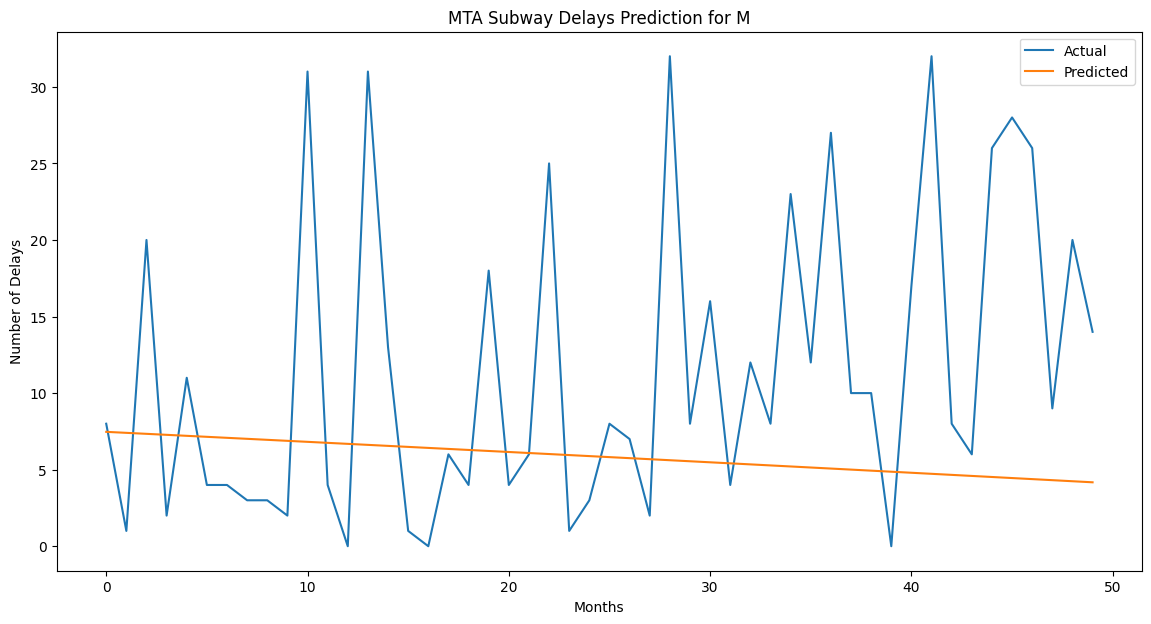

In [98]:
y_pred_scaled, y_test_scaled = model(X_train, y_train, X_test, y_test)
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_scaled, label='Actual')
plt.plot(y_pred_scaled, label='Predicted')

plt.title(f'MTA Subway Delays Prediction for {group_to_use[-1]}')
plt.ylabel("Number of Delays")
plt.xlabel("Months")
plt.legend()
plt.show()